In [1]:
import os
current_path = os.getcwd()
import numpy as np
from numpy import seterr
seterr(all='raise')
import matplotlib.pyplot as plt
import math
import random
from tqdm import tqdm
import sys
sys.path.append(current_path)
sys.path.append(current_path+'/../../')
import myInput
import PACKAGE_MP_Linear as linear2d
import post_processing
import PACKAGE_MP_3DLinear as Linear_3D
import PACKAGE_MP_3DVertex as Vertex_3D
sys.path.append(current_path+'/../calculate_tangent/')

import importlib
importlib.reload(post_processing)
importlib.reload(Linear_3D)
importlib.reload(linear2d)


<module 'PACKAGE_MP_Linear' from '/home/lin.yang/projects/VECTOR/examples/GB_velocity/../../PACKAGE_MP_Linear.py'>

## 2D case

In [2]:
if __name__ == '__main__':
    # File name
    init_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_multiCoreCompare/IC/"
    data_file_folder = "/blue/michael.tonks/lin.yang/VECTOR_data/"
    npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_fully/results/"
    # npy_file_folder = "/blue/michael.tonks/lin.yang/SPPARKS-VirtualIncEnergy/2d_poly_wellEnergy/results/"
    case_name = "20k"
    init_file_name = f"Case4.init"
    npy_file_name_aniso = f"p_aveE_fzab_fully5d_20k_J1_f1.0_t1.0_refer_1_0_0_seed56689_kt0.66.npy"
    # npy_file_name_aniso = f"p_aveE_20000_Cos_delta0.0_J1_refer_1_0_0_seed56689_kt0.66.npy"
    
    # Initial data
    npy_file_aniso = np.load(npy_file_folder + npy_file_name_aniso)
    npy_file_aniso = npy_file_aniso.astype(int)
    print(f"The {case_name} data size is: {npy_file_aniso.shape}")
    print("READING DATA DONE")
    step_num, size_x, size_y, size_z = npy_file_aniso.shape
    

The 20k data size is: (121, 2400, 2400, 1)
READING DATA DONE


In [3]:
    # misorientation calculation preparation
    grain_nums = 20000
    Osym = 24
    symm2quat_matrix, quartAngle = post_processing.pre_operation_misorientation(grain_nums, init_file_folder + init_file_name, Osym)
    miso_dict = dict()
    print("> Pre-work done")

> Pre-work done


In [4]:
    # Read the GB area!!
    step_num = 121
    GB_infomation_dict_list = []
    for time_step in tqdm(range(step_num)):
        data_file_name = f"GB_velocity_data/2D_curvature_velocity_data_MI_{case_name}_step{time_step}.npz"
        if os.path.exists(data_file_folder + data_file_name):
            npz_file = np.load(data_file_folder + data_file_name,allow_pickle=True)
            GB_infomation_dict = npz_file["GB_infomation_dict"]
            GB_infomation_dict_list.append(GB_infomation_dict.item())
        else:
            print("> You need to finish the velocity-curvature calculation or velocity-inclination calculation first")
            

100%|██████████| 121/121 [00:01<00:00, 91.36it/s]


In [5]:
    # Get the list of velocity and misorientation
    
    
    time_interval = 2
    GB_list_velocity = np.zeros((step_num,int(grain_nums*(grain_nums+1)/2)))
    GB_list_velocity_list = []
    GB_list_misorientation_angle_list = []
    GB_list_misorientation_axis_list = []
    for time_step in range(step_num):
        if time_step+1 >= step_num: continue
        GB_list_velocity_list_tmp = []
        GB_list_misorientation_angle_list_tmp = []
        GB_list_misorientation_axis_list_tmp = []
        for key in tqdm(GB_infomation_dict_list[time_step]):
            if GB_infomation_dict_list[time_step+1].get(key) is None: continue
            # Calculate volumn change
            pair_id_pair = GB_infomation_dict_list[time_step][key][6:8]
            growth_direction1 = (npy_file_aniso[time_step]==pair_id_pair[0])*(npy_file_aniso[time_step+1]==pair_id_pair[1])
            growth_direction2 = (npy_file_aniso[time_step]==pair_id_pair[1])*(npy_file_aniso[time_step+1]==pair_id_pair[0])
            dV = abs(np.sum(growth_direction1)-np.sum(growth_direction2))
            # Calculate velocity
            velocity = dV/time_interval/(GB_infomation_dict_list[time_step][key][5]/2)
            GB_list_velocity_list_tmp.append(velocity)
            
            # Calculate misorientation
            if key in miso_dict:
                misorientation_angle = miso_dict[key][0]
                misorientation_axis = miso_dict[key][1:]
                GB_list_misorientation_angle_list_tmp.append(misorientation_angle)
                GB_list_misorientation_axis_list_tmp.append(misorientation_axis)
            else:
                misorientation = post_processing.multiP_calM(list(map(int,GB_infomation_dict_list[time_step][key][6:8])), quartAngle, symm2quat_matrix, Osym)
                misorientation_angle = misorientation[0] # miso angle
                misorientation_axis = misorientation[1:]
                miso_dict[key] = misorientation
                GB_list_misorientation_angle_list_tmp.append(misorientation_angle)
                GB_list_misorientation_axis_list_tmp.append(misorientation_axis)
            
        GB_list_velocity_list.append(GB_list_velocity_list_tmp)
        GB_list_misorientation_angle_list.append(GB_list_misorientation_angle_list_tmp)
        GB_list_misorientation_axis_list.append(GB_list_misorientation_axis_list_tmp)
            

 96%|█████████▋| 17994/18679 [12:12<00:42, 16.02it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 83%|████████▎ | 6378/7690 [02:42<00:34, 37.95it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

  0%|          | 15/3183 [00:00<01:18, 40.39it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

<Figure size 432x288 with 0 Axes>

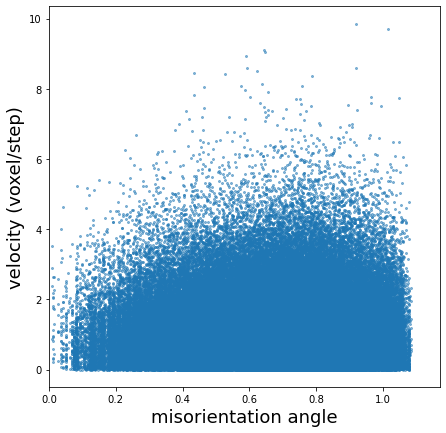

<Figure size 432x288 with 0 Axes>

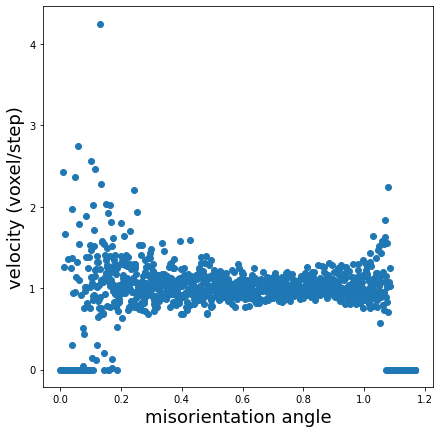

In [20]:
    # All in 1 figrue
    misorientation_angle_1Dlist_remove_0step = []
    misorientation_axis_1Dlist_remove_0step = []
    velocity_1Dlist_remove_0step = []
    for i in range(1,len(GB_list_velocity_list)): 
        misorientation_angle_1Dlist_remove_0step.extend(GB_list_misorientation_angle_list[i])
        misorientation_axis_1Dlist_remove_0step.extend(GB_list_misorientation_axis_list[i])
        velocity_1Dlist_remove_0step.extend(GB_list_velocity_list[i])
    
    figure_name_all = f"figures/2D_velocity_misorientation_angle_MI_{case_name}_5d.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.scatter(misorientation_angle_1Dlist_remove_0step, velocity_1Dlist_remove_0step,s=4,alpha=0.5)
    plt.xlabel("misorientation angle", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    plt.xlim([0,67/180*np.pi])
    # plt.ylim([0,10])
    plt.savefig(figure_name_all, dpi=400,bbox_inches='tight')
    
    # plot velocity VS averaged misorientation_angle
    bin_interval = 0.001
    max_bin_value = 67/180*np.pi
    bin_number = int(max_bin_value/bin_interval)
    misorientation_angle_coordinate = np.arange(0,max_bin_value,bin_interval)+bin_interval/2

    misorientation_angle_bin = np.zeros(bin_number)
    velocity_bin = np.zeros(bin_number)
    for index in range(len(misorientation_angle_1Dlist_remove_0step)):
        if misorientation_angle_1Dlist_remove_0step[index]>max_bin_value: continue
        misorientation_angle_bin[int(misorientation_angle_1Dlist_remove_0step[index]//bin_interval)] += 1
        velocity_bin[int(misorientation_angle_1Dlist_remove_0step[index]//bin_interval)] += velocity_1Dlist_remove_0step[index]
    for i in range(bin_number): 
        if misorientation_angle_bin[i]>0: velocity_bin[i] = velocity_bin[i]/misorientation_angle_bin[i]
    # plot
    figure_name_all_bin = f"figures/2D_velocity_misorientation_MI_{case_name}_5d_afterBin.png"
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.plot(misorientation_angle_coordinate[:-1], velocity_bin,'o', linewidth=2)
    plt.xlabel("misorientation angle", fontsize=18)
    plt.ylabel("velocity (voxel/step)", fontsize=18)
    # plt.xlim([0,0.6])
    # plt.ylim([0,5])
    plt.savefig(figure_name_all_bin, dpi=400,bbox_inches='tight')


Text(122.0, 59.3, '[111]')

<Figure size 432x288 with 0 Axes>

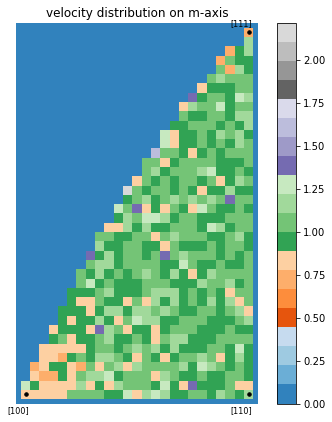

In [38]:
    
    bin_num = 200
    misorientation_axis_matrix = np.zeros((bin_num,bin_num))
    velocity_bin = np.zeros((bin_num,bin_num))
    
    for i in range(len(misorientation_axis_1Dlist_remove_0step)):
        misorientation_axis = misorientation_axis_1Dlist_remove_0step[i]
        # Get polar and azimuth dsitribution
        m_polar_angle = math.acos(round(misorientation_axis[2],3))
        m_azimuth_angle = math.atan2(misorientation_axis[1], misorientation_axis[0]) + np.pi
        if m_polar_angle < 0 or m_polar_angle > np.pi or m_azimuth_angle < 0 or m_azimuth_angle > 2*np.pi: print(">>> Please check the misorientation axis calculation!") # check angle error
        m_polar_angle_index = int(m_polar_angle//(np.pi/bin_num)) # get angle index to check the angle distribution
        m_azimuth_angle_index = int(m_azimuth_angle//(2*np.pi/bin_num)) # get angle index to check the angle distribution
        
        # Get polar and azimuth dsitribution in matrix
        x_index = m_polar_angle_index
        y_index = m_azimuth_angle_index
        if m_polar_angle_index == bin_num: x_index = x_index - 1
        if m_azimuth_angle_index == bin_num: y_index = y_index - 1
        misorientation_axis_matrix[x_index, y_index] += 1
        velocity_bin[x_index,y_index] += velocity_1Dlist_remove_0step[i]
    
    for i in range(bin_num):
        for j in range(bin_num):
            if misorientation_axis_matrix[i,j]>0: velocity_bin[i,j] = velocity_bin[i,j]/misorientation_axis_matrix[i,j]
                        
    
    # plot matrix figure for misorientation axis distribution
    # 100, 110, 111
    axis_100 = [bin_num/2, int(0.5*np.pi//(np.pi/bin_num))]
    axis_110 = [bin_num/2+int(0.25*np.pi//(2*np.pi/bin_num)), int(0.5*np.pi//(np.pi/bin_num))]
    axis_111 = [bin_num/2+int(0.25*np.pi//(2*np.pi/bin_num)),int(0.9553//(np.pi/bin_num))]
    X, Y = np.meshgrid(np.arange(bin_num),np.arange(bin_num))
    plt.figure()
    fig = plt.figure(figsize=(7, 7))
    plt.imshow(velocity_bin,cmap='tab20c')#,vmin=0,vmax=np.max(misorientation_axis_matrix_norm_list))
    # plt.contourf(X, Y, velocity_bin, 5,cmap='viridis_r')
    plt.xlabel(r"Misorientation Axis Azimuth Angle ($^\circ$)", fontsize=16)
    plt.ylabel(r"Misorientation Axis Polar Angle ($^\circ$)", fontsize=16)
    plt.xticks(np.linspace(0,bin_num,5), ['0',r'$\pi/2$',r'$\pi$',r'3$\pi$/2',r'2$\pi$'])
    plt.yticks(np.linspace(0,bin_num,3), ['0',r'$\pi/2$',r'$\pi$'])
    plt.xlim([bin_num/2-1,bin_num/8+bin_num/2])
    plt.ylim([bin_num/2,int(0.9553//(np.pi/bin_num)-1)])
    plt.title(f"velocity distribution on m-axis")
    plt.axis("off")
    plt.colorbar()
    plt.scatter(axis_100[0],axis_100[1],c='k',s=12)
    plt.text(axis_100[0]-2, axis_100[1]+2, "[100]", fontsize=8)
    plt.scatter(axis_110[0],axis_110[1],c='k',s=12)
    plt.text(axis_110[0]-2, axis_110[1]+2, "[110]", fontsize=8)
    plt.scatter(axis_111[0],axis_111[1],c='k',s=12)
    plt.text(axis_111[0]-2, axis_111[1]-0.7, "[111]", fontsize=8)